# Segmentation


Как скачать данные из Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
# files.upload()

In [ ]:
api_token = {"username":"USERNAME","key":"API_KEY"}

import json
import zipfile
import os
os.makedirs('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tapakah68/segmentation-full-body-mads-dataset

 97% 459M/474M [00:03<00:00, 134MB/s]
100% 474M/474M [00:03<00:00, 151MB/s]


In [ ]:
!unzip -n -q /content/segmentation-full-body-mads-dataset.zip

In [ ]:
!ls /content/segmentation_full_body_mads_dataset_1192_img

collages  images  masks


In [ ]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision import models

from skimage import data

from PIL import Image

from tqdm.notebook import trange, tqdm

from sklearn.model_selection import train_test_split

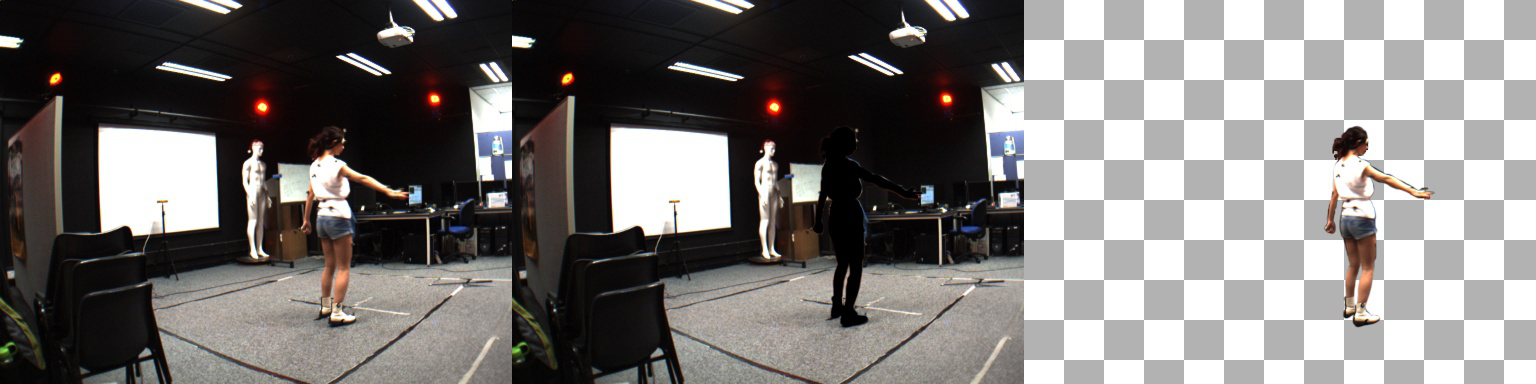

In [ ]:
image_name = 'Jazz_Jazz4_C2_00495.jpg'
Image.open("/content/segmentation_full_body_mads_dataset_1192_img/collages/" + image_name)

In [ ]:
imgs = sorted(os.listdir("/content/segmentation_full_body_mads_dataset_1192_img/images"))

In [ ]:
imgs[0]

'HipHop_HipHop1_C0_00180.png'

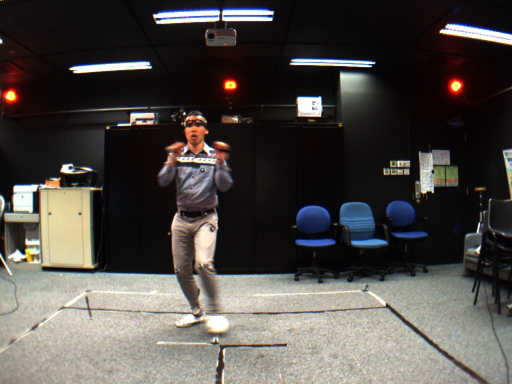

In [ ]:
Image.open("/content/segmentation_full_body_mads_dataset_1192_img/images/" + imgs[0])

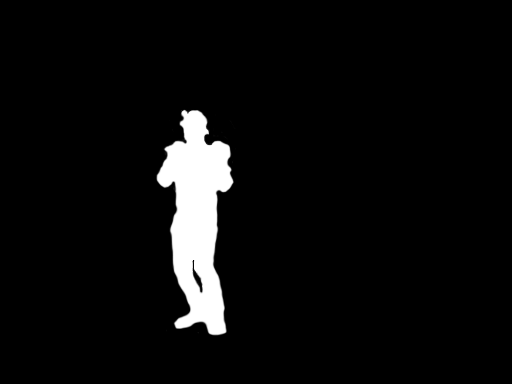

In [ ]:
Image.open("/content/segmentation_full_body_mads_dataset_1192_img/masks/" + imgs[0])

In [ ]:
img = Image.open("/content/segmentation_full_body_mads_dataset_1192_img/images/" + imgs[0])

In [ ]:
img.size

(512, 384)

In [ ]:
# transforms.Pad([(572 - 512) // 2, (572 - 384) // 2])(img)

In [ ]:
class SegmentationDataset(torch.utils.data.Dataset):
  def __init__(self, image_path, mask_path, imgs, transforms):	
    self.image_path = image_path
    self.mask_path = mask_path
    self.imgs = imgs
    self.transforms = transforms

  def __len__(self):
    return len(self.imgs)
  
  def __getitem__(self, idx):
    image_path = os.path.join(self.image_path, self.imgs[idx])
    mask_path = os.path.join(self.mask_path, self.imgs[idx])

    image = Image.open(image_path)
    mask = Image.open(mask_path).convert('L')
    
    # check to see if we are applying any transformations
    if self.transforms is not None:
      # apply the transformations to both image and its mask
      image = self.transforms(image)
      mask = transforms.ToTensor()(mask)
    # return a tuple of the image and its mask
    return (image, mask)

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
batch_size = 16

trainset = SegmentationDataset(
    "/content/segmentation_full_body_mads_dataset_1192_img/images",
    "/content/segmentation_full_body_mads_dataset_1192_img/masks",
    imgs, 
    train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
inputs, masks = next(iter(trainloader))

In [ ]:
inputs.shape, masks.shape

(torch.Size([16, 3, 384, 512]), torch.Size([16, 1, 384, 512]))

# SegNet
SegNet : A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation

Original paper: https://arxiv.org/pdf/1511.00561.pdf

Pytorch implementation
https://github.com/vinceecws/SegNet_PyTorch/blob/master/SegNet.py

![](https://user-images.githubusercontent.com/19466657/120553062-0df47e80-c3c6-11eb-9355-cd0f5d449752.png)

## Classic U-net
U-Net: Convolutional Networks for Biomedical Image Segmentation


![image.png](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)


Implementation

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

![](https://www.researchgate.net/profile/Thanh-Nguyen-160/publication/317493482/figure/fig6/AS:639677962915851@1529522519694/U-net-Convolutional-Neural-Network-model-The-U-net-model-contains-two-parts.png)

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [ ]:
enc_block = Block(1, 64)
x         = torch.randn(1, 1, 512, 384)
enc_block(x).shape

torch.Size([1, 64, 512, 384])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


In [ ]:
encoder = Encoder()
# input image
x    = torch.randn(1, 3, 384, 512)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)
  

torch.Size([1, 64, 384, 512])
torch.Size([1, 128, 192, 256])
torch.Size([1, 256, 96, 128])
torch.Size([1, 512, 48, 64])
torch.Size([1, 1024, 24, 32])


In [ ]:
class Decoder(nn.Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = nn.ModuleList(
			[nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = nn.ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
	 
			x = torch.cat([x, encFeatures[i]], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x

In [ ]:
class UNet(nn.Module):
  def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
    # initialize the regression head and store the class variables
    self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
  
  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0],
      encFeatures[::-1][1:])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.head(decFeatures)
    
    return map

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
net = UNet()

In [ ]:
x    = torch.randn(1, 3, 384, 512)
net(x).shape

torch.Size([1, 1, 384, 512])

In [ ]:
# initialize our UNet model
unet = UNet().to(device)

criterion = nn.BCEWithLogitsLoss()
opt = optim.AdamW(unet.parameters(), lr=0.001)

In [ ]:
for e in range(4):
  running_loss = 0.0
  i = 0
  unet.train()
	
  for x, y in tqdm(trainloader):
    x = x.to(device) 
    y = y.to(device)

    pred = unet(x)
    loss = criterion(pred, y)
		
    opt.zero_grad()
    loss.backward()
    opt.step()
		
    running_loss += loss.item()
    if i % 10 == 9:
        print(f"Loss: {running_loss / 10}")
        running_loss = 0
    i += 1

  0%|          | 0/75 [00:00<?, ?it/s]

Loss: 0.5448415100574493
Loss: 0.21702600717544557
Loss: 0.1841664880514145
Loss: 0.18382907658815384
Loss: 0.1660625547170639
Loss: 0.15928953886032104
Loss: 0.14582274854183197


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: 0.13926730304956436
Loss: 0.1395119920372963
Loss: 0.1263852171599865
Loss: 0.12353111132979393
Loss: 0.11915855035185814
Loss: 0.11013997197151185
Loss: 0.10101901441812515


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: 0.17363313287496568
Loss: 0.1324934408068657
Loss: 0.12106607109308243
Loss: 0.11024651601910591
Loss: 0.0975556381046772
Loss: 0.09269977882504463
Loss: 0.10320468097925187


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: 0.09725436642765999
Loss: 0.09186268523335457
Loss: 0.07410213649272919
Loss: 0.07080700695514679
Loss: 0.07482272461056709
Loss: 0.06310884132981301
Loss: 0.06313369534909725


In [ ]:
inputs, masks = next(iter(trainloader))

with torch.no_grad():
  pred = torch.sigmoid(unet(inputs.to(device)))

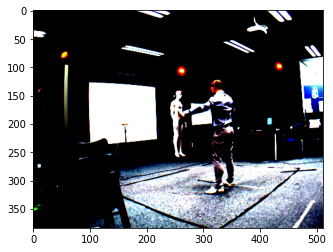

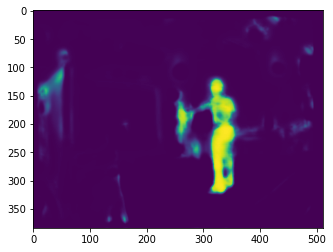

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

npimg = inputs[0].detach().cpu().numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

npimg = pred[0, 0].detach().cpu().numpy()
plt.imshow(npimg)
plt.show()

# DeepLab



## Dilated Convolution
![](https://www.researchgate.net/publication/336002670/figure/fig1/AS:806667134455815@1569335840531/An-illustration-of-the-receptive-field-for-one-dilated-convolution-with-different.png)

https://arxiv.org/pdf/1706.05587.pdf

In [ ]:
from torchvision import models

weights = models.ResNet18_Weights.IMAGENET1K_V1

resnet = models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
f_resnet = nn.Sequential(*list(resnet.children())[:-3])

In [ ]:
inputs, masks = next(iter(trainloader))

In [ ]:
f_resnet(inputs).shape

torch.Size([16, 256, 24, 32])

In [ ]:
class ASPP(nn.Module):
    def __init__(self, num_classes):
        super(ASPP, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(256, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(256, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 256, h/16, w/16)) 

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        out_img = F.interpolate(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))

        return out

In [ ]:
class DeepLabV3(nn.Module):
    def __init__(self, f_resnet, num_classes):
        super(DeepLabV3, self).__init__()

        self.f_resnet = f_resnet
        self.aspp = ASPP(num_classes=num_classes) 

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        h = x.size()[2]
        w = x.size()[3]

        feature_map = self.f_resnet(x) # (shape: (batch_size, 256, h/16, w/16)) 
        output = self.aspp(feature_map) # (shape: (batch_size, num_classes, h/16, w/16))

        output = F.interpolate(output, size=(h, w), mode="bilinear") # (shape: (batch_size, num_classes, h, w))

        return output

In [ ]:
net = DeepLabV3(f_resnet, 1)

In [ ]:
net(inputs).shape

torch.Size([16, 1, 384, 512])

In [ ]:
# initialize our UNet model
net = DeepLabV3(f_resnet, 1).to(device)

criterion = nn.BCEWithLogitsLoss()
opt = optim.Adagrad(net.parameters(), lr=0.001)

In [ ]:
for e in range(4):
  running_loss = 0.0
  i = 0
  net.train()
	
  for x, y in tqdm(trainloader):
    x = x.to(device) 
    y = y.to(device)

    pred = net(x)
    loss = criterion(pred, y)
		
    opt.zero_grad()
    loss.backward()
    opt.step()
		
    running_loss += loss.item()
    if i % 10 == 9:
        print(f"Loss: {running_loss / 10}")
        running_loss = 0
    i += 1

  0%|          | 0/75 [00:00<?, ?it/s]

Loss: 0.4375124484300613
Loss: 0.17010416388511657
Loss: 0.13348476588726044
Loss: 0.11640894785523415
Loss: 0.10404503718018532
Loss: 0.0967971719801426
Loss: 0.0899548850953579


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: 0.08236955404281616
Loss: 0.07932796999812126
Loss: 0.07565773054957389
Loss: 0.07192386388778686
Loss: 0.07095045745372772
Loss: 0.06793304532766342
Loss: 0.06511311456561089


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: 0.06246679313480854
Loss: 0.06107727065682411
Loss: 0.0590838335454464
Loss: 0.05863112881779671
Loss: 0.056237148493528365
Loss: 0.055475179105997086
Loss: 0.05398727506399155


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: 0.052369315177202225
Loss: 0.05089032724499702
Loss: 0.050442615523934364
Loss: 0.05013615041971207
Loss: 0.04934651553630829
Loss: 0.04811503514647484
Loss: 0.04749537445604801


In [ ]:
inputs, masks = next(iter(trainloader))

with torch.no_grad():
  pred = torch.sigmoid(net(inputs.to(device)))

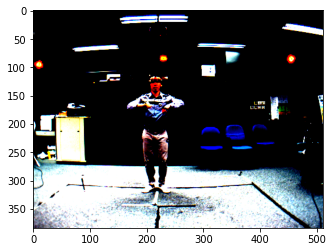

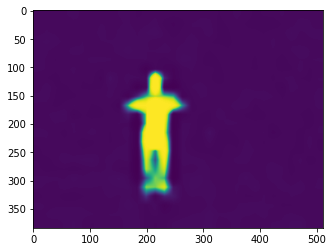

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

npimg = inputs[0].detach().cpu().numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

npimg = pred[0, 0].detach().cpu().numpy()
plt.imshow(npimg)
plt.show()